<span style='font-size:22px;'>**Проект: 
    выгружаем данные из VK API, обрабатываем, отправляем ежемесячный отчет в Telegram**</span>


**Задача - сделать программу, которая присылает статистику о просмотре видео в группе VK:**
- вытащить из VK API данные о просмотрах видео, реакциях и репостах
- посчитать их кол-во за предыдущий месяц 
- автоматически 1-го числа каждого месяца (либо по любому расписанию, либо сию минуту) присылать в Telegram отчет со статистикой в виде текста и графика за предыдущий месяц

**Что сделано:**
- я написала на python код для того, чтобы выгрузить нужные мне данные из VK API
- данные по видео вытягивались только по 200 за раз, в моем случае видео было больше, поэтому был использован параметр offset, чтобы вытащить 200, затем начать с 200+1, вытащить еще 200 и начать с 400+1 и т.д.
- вытащенный файл представлял из себя словарь, я сделала из него датафрейм
- дата была в формате unixtime, поменяла формат на datetime, т.к. четкая правильная дата - важный параметр для этого проекта
- добавила колонки с месяцами и годами публикации, по ним затем делала группировку
- сделала агрегацию - посчитала кол-во просмотров по месяцам 
- ограничившись показом последних 6 месяцев, написала код для отрисовки столбчатой диаграммы с подписями над каждым столбцом с помощью matplotlib и seaborn
- написала код для сохранения диаграммы в файл png и его отправки через бот в группу Telegram
- сохранила сообщение с информацией о кол-ве лайков, репостов и просмотров в текстовом виде и написала код для его отправки через бот в группу Telegram
- обернула все это в функцию fetch_and_save_vk_data


**Написала код для DAG (с использованием этой функции) со следующими основными параметрами:**
- код выполняется раз в месяц 1 числа каждого месяца
- три попытки на retry (с промежутком в 5 минут)


**Затем:**
- установила Docker
- взяла готовые образы на Docker Hub, чтобы развернуть Airflow
- нужно было доустановить зависимости matplotlib и seaborn, для этого создала для каждого образа отдельный файл requirements.txt, затем на основе скачанных образов создала свои образы, установив в них свои requirements
- примонтировала локальные папки, в которые можно класть файлы с DAG-ами + в которых можно смотреть логи
- с помощью Docker-Compose развернула все компоненты Airflow
- в Airflow UI запустила DAG


##  импорт библиотек

In [1]:
pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
import os
from datetime import datetime, timedelta
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##  объявление главных переменных

In [3]:
load_dotenv('/Users/yulialatysheva/vk_api/my.env') 
# здесь я сделала так, чтобы токены хранились локально, 
# но если очень хочется, их можно ввести напрямую в переменные

# токен api telegram
telegram_token = os.getenv("telegram_token")

# айди чата/группы, куда будем отправлять отчеты
telegram_chat_id = os.getenv("telegram_chat_id")

# токен для доступа к api vk
vk_token = os.getenv("vk_token")

# айди группы вк, откуда будем тянуть данные для статистики
vk_group_id = os.getenv("vk_group_id")

### как я получила токены для VK и Telegram, а также id чата в Telegram и группы VK

**Токен для доступа к API Telegram**
- создала бота через бот @botfather
- дала ему имя
- после назначения имени бот прислал мне токен в ответном сообщении


**Токен для VK API**
- его можно получить здесь: https://vkhost.github.io


**ID чата в Telegram** (может быть личный чат или группа)
- **для группы** использован @LeadConverterToolkitBot, он был добавлен в группу с правом отправлять сообщения
- отправила в группу команду /get_chat_id@LeadConverterToolkitBot
- в ответ получила id группы
- удалила бота из группы


- **для личного аккаунта** - узнала id при помощи бота @getmyid_bot
- отправила ему команду /start, получила в ответном сообщении мой id


**ID группы VK**
- в моем случае у группы был буквенный адрес (по названию группы), но id легко посмотреть, открыв любое фото или видео в группе: смотрю адресную строку и беру в ней первую комбинацию из 8 цифр, это и есть мой id группы 




##  запрос к api vk и составление словаря

In [4]:
url = f"https://api.vk.com/method/video.get?v=5.131&owner_id=-{vk_group_id}&access_token={vk_token}"
response = requests.get(url)
data = response.json()

video_count = data['response']['count']

count = 200
offset = 0
video_data = []

while offset <= video_count:
    url = f"https://api.vk.com/method/video.get?v=5.131&owner_id=-{vk_group_id}&access_token={vk_token}&count={count}&offset={offset}"
    response = requests.get(url)
    data = response.json()
    videos = data['response']['items']
        
    for video in videos:
        video_info = {
            "id": video['id'],
            "name": video['title'],
            "add_date": datetime.fromtimestamp(video['date']).strftime('%Y-%m-%d'), 
            "views": video['views'],
            "likes_count": video['likes']['count'] if 'likes' in video else 0,
            "reposts": video['reposts']['count'] if 'reposts' in video else 0
        }
        video_data.append(video_info)
            
    offset += count

##  делаю из словаря df и группирую по году и месяцу

In [5]:
vkvideos = pd.DataFrame(video_data)
vkvideos['add_date'] = pd.to_datetime(vkvideos['add_date'])
vkvideos['year'] = vkvideos['add_date'].dt.year
vkvideos['month'] = vkvideos['add_date'].dt.month

##  агрегация, сортировка, подготовка к созданию графика и сообщения txt

In [6]:
current_date = datetime.now()
views_current_month = vkvideos[(vkvideos['year'] == current_date.year) & (vkvideos['month'] == current_date.month)]
total_views_current_month = views_current_month['views'].sum()

In [ ]:
# создаю новые столбцы 'year' и 'month' с годом и месяцем соответственно
vkvideos['year'] = vkvideos['add_date'].dt.year
vkvideos['month'] = vkvideos['add_date'].dt.month

In [ ]:
# получу первый день предыдущего месяца
first_day_previous_month = datetime.now().replace(day=1) - timedelta(days=1)
previous_month_year = first_day_previous_month.year
previous_month = first_day_previous_month.month

In [ ]:
# беру видео за предыдущий месяц
videos_previous_month = vkvideos[(vkvideos['year'] == previous_month_year) & (vkvideos['month'] == previous_month)]

# нахожу видео с максимальным количеством просмотров за предыдущий месяц
most_popular_video = videos_previous_month[videos_previous_month['views'] == videos_previous_month['views'].max()]

# беру название и кол-во просмотров самого популярного видео
most_popular_video_title = most_popular_video.iloc[0]['name']
most_popular_video_views = most_popular_video.iloc[0]['views']

In [ ]:
# собираю кол-во просмотров, лайков, репостов, плюс среднее кол-во просмотров. все - за предыдущий месяц
views_previous_month = vkvideos[(vkvideos['year'] == previous_month_year) & (vkvideos['month'] == previous_month)]
total_views_previous_month = views_previous_month['views'].sum()
total_likes_previous_month = views_previous_month['likes_count'].sum()
total_reposts_previous_month = views_previous_month['reposts'].sum()
average_views_previous_month = round(total_views_previous_month / len(views_previous_month))

In [ ]:
# группирую данные по году и месяцу и считаю сумму просмотров
monthly_views = vkvideos.groupby(['year', 'month'])['views'].sum()

# преобразую объект Series в DataFrame
monthly_views_df = monthly_views.reset_index()

# переименую столбец с суммой просмотров
monthly_views_df = monthly_views_df.rename(columns={'views': 'общее кол-во просмотров'})

In [ ]:
# сортирую по убыванию
monthly_views_sorted = monthly_views_df.sort_values(by=['year', 'month'], ascending=False)
monthly_views_sorted = monthly_views_sorted.rename(columns={'year': 'год', 'month': 'месяц'})

In [9]:
# беру только последние 6 мес
last_six_months = monthly_views_sorted.head(6)

##  рисую график, сохраняю его и отправляю

<Response [200]>

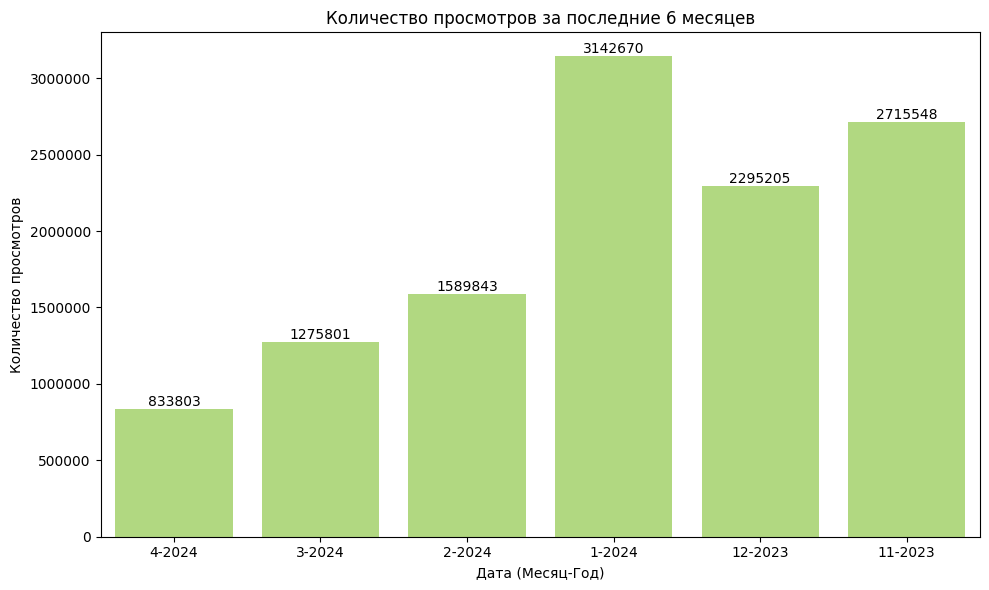

In [7]:
# рисую барплот
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=last_six_months['месяц'].astype(str) + '-' + last_six_months['год'].astype(str), y=last_six_months['общее кол-во просмотров'], palette=['#B2E672'])

# добавляю подписи над каждым столбцом
for i, v in enumerate(last_six_months['общее кол-во просмотров']):
    plt.text(i, v + 10, str(round(v, 2)), ha='center', va='bottom')

# добавляю подписи осей
plt.xlabel('Дата (Месяц-Год)')
plt.ylabel('Количество просмотров')
plt.title('Количество просмотров за последние 6 месяцев')
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)  # убираю экспоненциальное отображение
plt.tight_layout()

# сохраняю график в файл
plt.savefig('last_six_months_views.png') 
# в DAG-е будет сохраняться в папке контейнера докера 
# plt.savefig('/opt/bitnami/airflow/dags/last_six_months_views.png')

# отправляю через бот сообщение с изображением
url = f"https://api.telegram.org/bot{telegram_token}/sendPhoto"
files = {'photo': open('last_six_months_views.png', 'rb')}
data = {'chat_id': telegram_chat_id}
requests.post(url, files=files, data=data)

##  статистика в txt - собираю, отправляю

In [8]:
# сообщение с остальной информацией
message = f"В предыдущем месяце:\n" \
          f"- Просмотров - {total_views_previous_month}\n" \
          f"- Лайков - {total_likes_previous_month}\n" \
          f"- Репостов - {total_reposts_previous_month}\n" \
          f"- В среднем каждое видео смотрели {average_views_previous_month} раз(а)\n" \
          f"- Самое популярное видео: {most_popular_video_title} - {most_popular_video_views} просмотров\n" \
          f"\n" \
          f"Просмотров в этом месяце - {total_views_current_month}\n"

# отправляю через бот текстовое сообщение с остальной информацией
url = f"https://api.telegram.org/bot{telegram_token}/sendMessage?chat_id={telegram_chat_id}&text={message}"
print(requests.get(url).json())

{'ok': True, 'result': {'message_id': 29, 'from': {'id': 7153747618, 'is_bot': True, 'first_name': 'konztruktiv_bot', 'username': 'konztruktiv_bot'}, 'chat': {'id': 102470223, 'first_name': 'Yulia', 'username': 'yu_lisichkina', 'type': 'private'}, 'date': 1713994866, 'text': 'В предыдущем месяце:\n- Просмотров - 1275801\n- Лайков - 22755\n- Репостов - 307\n- В среднем каждое видео смотрели 16356 раз(а)\n- Самое популярное видео: Как изменилась жизнь в Мелитополе - 36065 просмотров\n\nПросмотров в этом месяце - 833803'}}


Если код запустить до этой ячейки, то он отработает и полный отчет с текстом и графиком придет в Telegram. Но мне нужно, чтобы всё происходило автоматически и по расписанию

##  делаю DAG  на основе кода выше 

## Вуаля, а вот он, результат!

Пример сообщения, которое присылает бот.


<a href="https://ibb.co/swTJGwD"><img src="https://i.ibb.co/R0X4m0M/IMG-8575.jpg" alt="IMG-8575" border="0" width="300" height="300" align="left"></a>


- Часто метрик, которые встроены в статистику ВК на сайте, недостаточно, и, например, кол-ва просмотров за месяц + в сравнении с предыдущими месяцами нам очень не хватало
- эту программу можно менять, вставляя любую нужную метрику, если понадобится что-то еще
- Рассылка бота приходила в рабочий чат, в котором состояли сотрудники отдела смм, что удобно - сразу все в курсе дел - падаем мы по просмотрам или растем
- если руководителю срочно был нужен отчет - свежие цифры + график рисовались за считаные минуты = мы довольны, руководитель тоже)

Такой получился результат. Первый самостоятельный проект успешно реализован, принес достаточно пользы, а прежде всего практического опыта. 


Кодом я поделюсь с коллегами из смм отделов других редакций, даже без Airflow могут запускать и пользоваться для отслеживания статистики своих сообществ ВК. 